# 14. Decision Trees

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/14.DecisionTrees.ipynb)

Slides and notebook based on https://www.datacamp.com/community/tutorials/decision-tree-classification-python, https://nanohub.org/tools/mseml/, https://machinelearningmastery.com/information-gain-and-mutual-information/.

We will use the Decision Tree Classifier Building in Scikit-learn.

Let's first load the required libraries.

In [1]:
# Install the mendeleev and poymatgen packages using pip in the current Jupyter kernel
# To use them, you may need to restart the kernel
import sys
!{sys.executable} -m pip install mendeleev
!{sys.executable} -m pip install pymatgen

import pymatgen as pymat
from pymatgen.core.periodic_table import Element
import mendeleev as mendel
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import sys

### Getting the dataset

We select 47 elements that occur in the fcc, hcp, and bcc structure. The elements listed were chosen because querying them for these properties yields a dataset with no unknown values, and because they represent the three most common crystallographic structures.

We then query both Pymatgen and Mendeleev to get a complete set of properties per element. We will use this data to create the features from which the model will train and test. 

In [2]:
fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Ca", "Cr", "Cs", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Rb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Ru", "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn", "Zr"]

elements = fcc_elements + bcc_elements + hcp_elements

random.Random(1).shuffle(elements)

querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point", "en_ghosh",  "evaporation_heat", "heat_of_formation",
                     "lattice_constant", "melting_point", "specific_heat"]
querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity","molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid", "coefficient_of_linear_thermal_expansion"]
querable_values = querable_mendeleev + querable_pymatgen

We will use the database queries to populate a pandas dataframe.

In [3]:
all_values = [] # Values for Attributes
all_labels = [] # Crystal structure labels (0 = fcc, 1 = bcc, 2 = hcp)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item)
    for i in querable_mendeleev:    
        element_values.append(getattr(element_object,i))

    # This section queries Pymatgen
    element_object = Element(item)    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object,i))
        
    all_values.append(element_values) # All lists are appended to another list, creating a List of Lists
    
    if (item in fcc_elements):
        all_labels.append(0) # The crystal structure labels are assigned here
    elif (item in bcc_elements):
        all_labels.append(1) # The crystal structure labels are assigned here
    elif (item in hcp_elements):
        all_labels.append(2) # The crystal structure labels are assigned here

# Pandas Dataframe
df = pd.DataFrame(all_values, columns=querable_values)

# We will patch some of the values that are not available in the datasets.

# Value for the CTE of Cesium
index_Cs = df.index[df['atomic_number'] == 55]
df.iloc[index_Cs, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000097 
# Value from: David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition. CRC Press. Boca Raton, Florida, 2003

# Value for the CTE of Rubidium
index_Rb = df.index[df['atomic_number'] == 37]
df.iloc[index_Rb, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000090 
# Value from: https://www.azom.com/article.aspx?ArticleID=1834

# Value for the Evaporation Heat of Ruthenium
index_Ru = df.index[df['atomic_number'] == 44]
df.iloc[index_Ru, df.columns.get_loc("evaporation_heat")] = 595 # kJ/mol 
# Value from: https://www.webelements.com/ruthenium/thermochemistry.html

# Value for the Bulk Modulus of Zirconium
index_Zr = df.index[df['atomic_number'] == 40]
df.iloc[index_Zr, df.columns.get_loc("bulk_modulus")] = 94 # GPa 
# Value from: https://materialsproject.org/materials/mp-131/

df.head(n=10)

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,lattice_constant,melting_point,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,youngs_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,27,6.70,3143.0,0.143236,389.1,426.7,2.51,1768.00,0.456,58.933195,1.35,6.000000e-08,6.67,180.0,209.0,0.768333,8900.0,0.000013
1,69,18.10,2220.0,0.216724,232.0,232.2,3.54,1818.00,0.160,168.934210,1.75,6.760000e-07,19.10,45.0,74.0,1.095000,9321.0,0.000013
2,39,19.80,3611.0,0.121699,367.0,424.7,3.65,1795.00,0.284,88.905850,1.80,6.000000e-07,19.88,41.0,64.0,1.040000,4472.0,0.000011
3,75,8.85,5900.0,0.243516,704.0,774.0,2.76,3453.00,0.138,186.207000,1.35,1.800000e-07,8.86,370.0,463.0,0.712500,21020.0,0.000006
4,28,6.60,3005.0,0.147207,378.6,430.1,3.52,1726.00,0.443,58.693400,1.35,7.200000e-08,6.59,180.0,200.0,0.740000,8908.0,0.000013
5,67,18.70,2968.0,0.207795,301.0,300.6,3.58,1747.00,0.164,164.930320,1.75,8.140000e-07,18.74,40.0,65.0,1.041000,8795.0,0.000011
6,79,10.20,3080.0,0.261370,340.0,368.2,4.08,1337.58,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,78.0,1.070000,19300.0,0.000014
7,21,15.00,3104.0,0.119383,332.7,377.8,3.31,1814.00,0.556,44.955912,1.60,5.500000e-07,15.00,57.0,74.0,0.885000,2985.0,0.000010
8,45,8.30,4000.0,0.140838,494.0,556.0,3.80,2239.00,0.244,102.905500,1.35,4.300000e-08,8.28,380.0,275.0,0.745000,12450.0,0.000008
9,74,9.53,5930.0,0.239050,824.0,851.0,3.16,3680.00,0.133,183.840000,1.35,5.400000e-08,9.47,310.0,411.0,0.766667,19250.0,0.000005


### Processing and Organizing Data

We normalize the data and randomly split it into training and testing sets.

##### SETS

We have 47 elements for which the crystal structure is known and we will use 40 of these as a training set and the remaining 7 as testing set.

##### NORMALIZATION

We will again use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.
$$
\frac{X - µ}{σ}
$$
While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [4]:
# SETS
all_values = [list(df.iloc[x]) for x in range(len(all_values))]

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow
# (Normalization).
all_values = np.array(all_values, dtype = float)
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = int)
print("Shape of Labels:", all_labels.shape)

# Training Set
train_values = all_values[:40, :]
train_labels = all_labels[:40]

# Testing Set
test_values = all_values[-7:, :]
test_labels = all_labels[-7:]

# NORMALIZATION

mean = np.nanmean(train_values, axis = 0) # mean
std = np.nanstd(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

print(train_values[0]) # print a sample entry from the training set
print(train_labels[0])

Shape of Values: (47, 18)
Shape of Labels: (47,)
[-0.80084167 -0.75983551 -0.00894162 -0.40732945  0.15599373  0.16654528
 -1.09549525  0.09455406  0.02631292 -0.82400017 -0.80570946 -0.67799461
 -0.75661221  0.70972845  0.6516648  -0.77257498  0.11409173 -0.3075323 ]
2


### Creating the Decision Tree Model

For this classification, we will use a simple decision tree.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Create Decision Tree classifer object
model = DecisionTreeClassifier()

# Train Decision Tree Classifer
model.fit(train_values, train_labels)

DecisionTreeClassifier()

### Validation

We calculate the accuracy score on the training and the testing sets.

In [6]:
#Predict the response for training and testing dataset
train_pred = model.predict(train_values)
test_pred = model.predict(test_values)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred))

Training accuracy = 1.000 
Testing accuracy  = 0.857 


### Visualize the decision tree

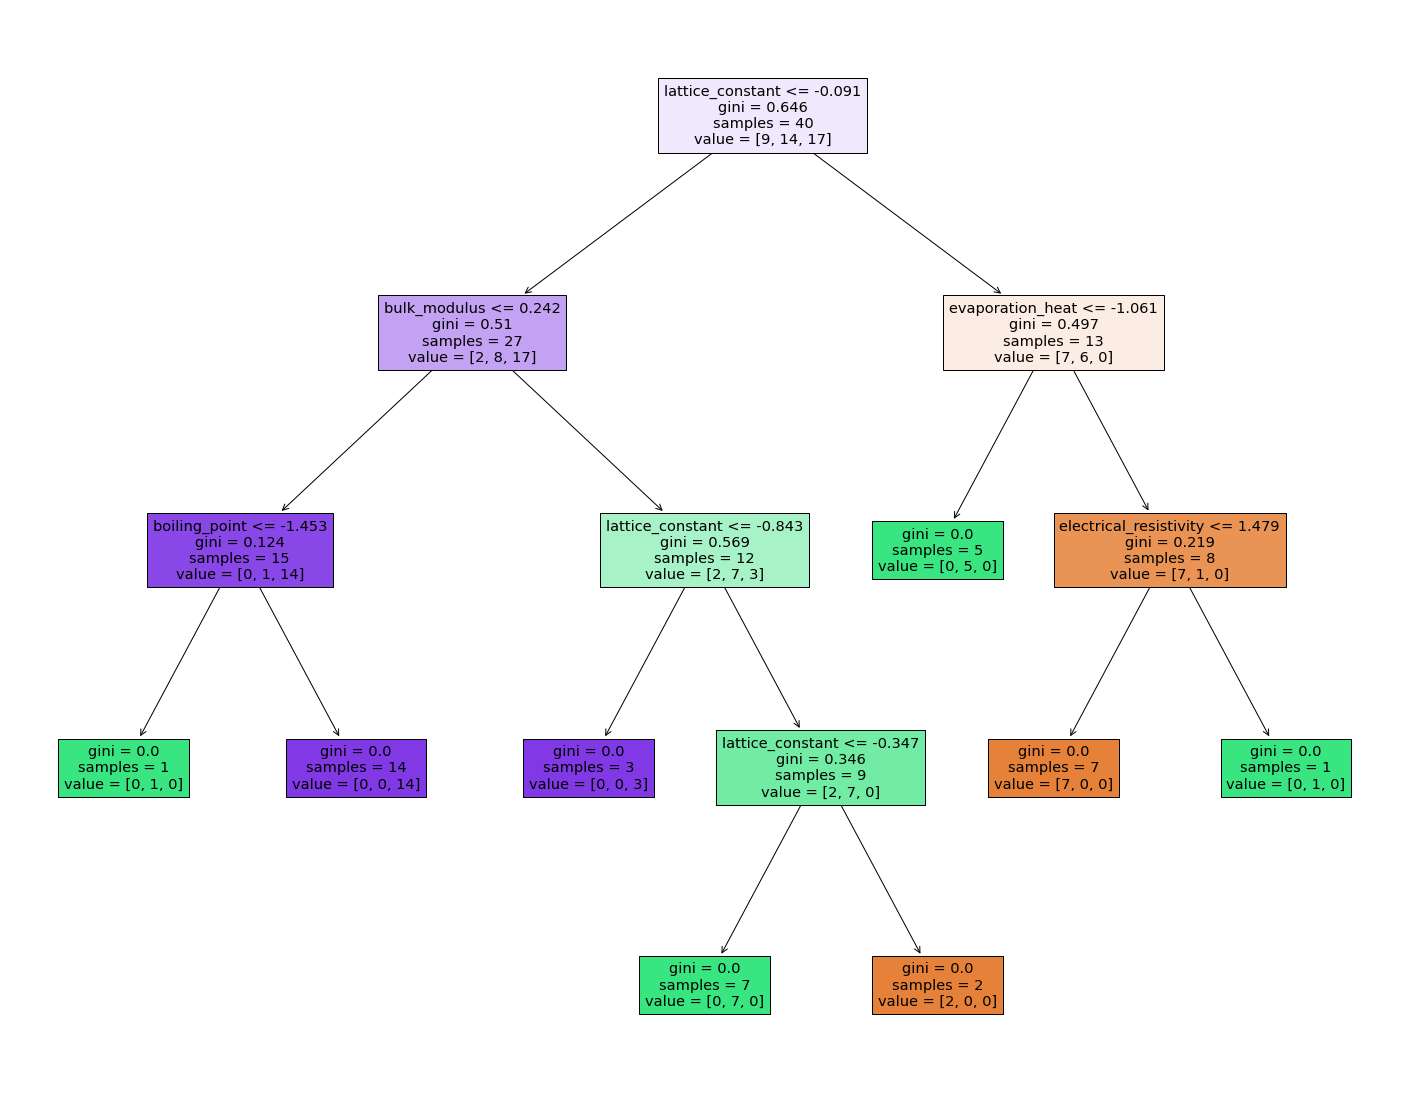

In [7]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=querable_values, filled=True)

In [8]:
train_predictions = model.predict(train_values)
test_predictions = model.predict(test_values)

print("train_labels = ", train_labels)
print("test_labels = ", test_labels)

all_labels = np.hstack((train_labels, test_labels))
all_predictions = np.hstack((train_predictions, test_predictions))

predicted_labels = []
true_labels = []

for i in range(all_predictions.shape[0]):
    if (all_predictions[i] == 0):
        predicted_labels.append("FCC")
    if (all_labels[i] == 0):
        true_labels.append("FCC")
    if (all_predictions[i] == 1):
        predicted_labels.append("BCC")
    if (all_labels[i] == 1):
        true_labels.append("BCC")
    if (all_predictions[i] == 2):
        predicted_labels.append("HCP")
    if (all_labels[i] == 2):
        true_labels.append("HCP")

predicted_labels = np.array(predicted_labels).reshape((-1, 1))
true_labels = np.array(true_labels).reshape((-1, 1))
headings = ["Atomic number", "True crystal structure", "Predicted crystal structure"]

atomic_number_array = np.array(df.iloc[:, 0]).reshape((-1, 1))
plot_table = np.concatenate((atomic_number_array, true_labels, predicted_labels), axis=1)

plot_df = pd.DataFrame(plot_table, columns=headings)

train_labels =  [2 2 2 2 0 2 0 2 0 1 2 2 2 0 1 2 1 1 1 1 1 2 0 0 1 2 1 1 2 1 1 0 2 2 0 2 0
 1 1 2]
test_labels =  [2 2 0 1 0 2 0]


In [9]:
plot_df

,Atomic number,True crystal structure,Predicted crystal structure
0,27,HCP,HCP
1,69,HCP,HCP
2,39,HCP,HCP
3,75,HCP,HCP
4,28,FCC,FCC
5,67,HCP,HCP
6,79,FCC,FCC
7,21,HCP,HCP
8,45,FCC,FCC
9,74,BCC,BCC


### Optimization of the decision tree

The default Attribute Selection Measure to determine the quality of a split for a decision node is Gini. We can try the Entropy measure and also see if we can reduce the depths of the tree.

In [10]:
# Create Decision Tree classifer object
model = DecisionTreeClassifier(criterion="entropy", max_depth=2)

# Train Decision Tree Classifer
model.fit(train_values, train_labels)

#Predict the response for training and testing dataset
train_pred = model.predict(train_values)
test_pred = model.predict(test_values)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred))

Training accuracy = 0.825 
Testing accuracy  = 0.857 


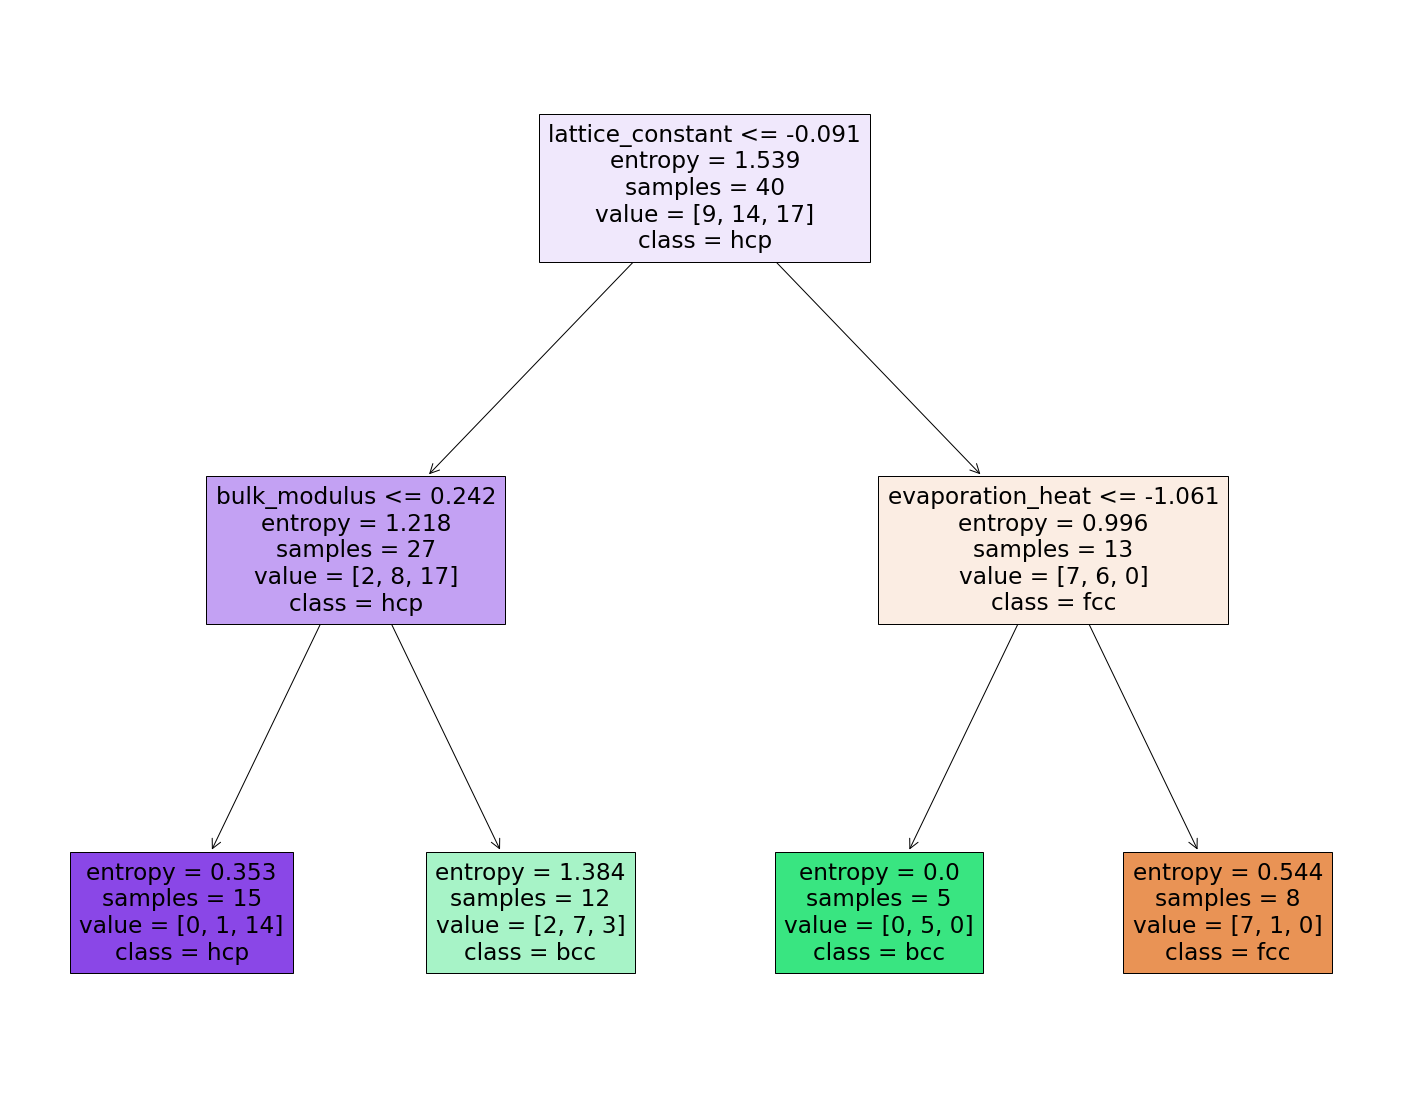

In [11]:
label_names = ('fcc', 'bcc', 'hcp')
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=querable_values, class_names = label_names, filled=True)

### Questions

#### Hyperparameter optimization

We can select different methods for the attribute selection measure (ASM) and also chose the maximum number of layers. Modify the maximum number of layers and determine what an optimal value is using the training and testing error.

#### Learning from the machine

1. How many parameters are optimized in the decision trees for each node?

2. Which features is most strongly correlated with the crystal structure?

3. What is the physical reason that this feature determines the crystal structure?

3. Should this feature be included in the model? 

4. How often does the decision tree identify the right structures if you remove this feature from the dataset?
Remove the appropriate column using the numpy delete command `np.delete(train_values, X-1, 1)`, which removes the column number X from the train_values array.

### Comparison with other machine learning methods

A tutorial on nanoHUB applies a neural network machine learning model to the same dataset for crystal structure predition, which we study here, see https://nanohub.org/tools/mseml/. That model optimizes a total of 350 parameters to achieve an accuracy:

`Training Set Accuracy: 1.000000`

`Testing Set Accuracy: 0.857143`

As we will see when we discuss neural networks, it is difficult to identify the importance of different features in a model.

Question: Based on this information, what are some of the advantages of a decision tree model for this specific dataset?

In [ ]:
# Set the column for the feature to be removed from the dataset
Remove_column = ??
train_values_del    = np.delete(train_values, Remove_column-1, 1)
test_values_del     = np.delete(test_values, Remove_column-1, 1)
querable_values_del = np.delete(querable_values, Remove_column-1, 0)

# Create Decision Tree classifer object
model = DecisionTreeClassifier(criterion="gini", max_depth=2)

# Train Decision Tree Classifer
model.fit(train_values_del, train_labels)

#Predict the response for training and testing dataset
train_pred_del = model.predict(train_values_del)
test_pred_del = model.predict(test_values_del)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred_del))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred_del))

# Plot the resulting decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=querable_values, class_names = label_names, filled=True)